In [12]:
import jax.numpy as jnp
from jax import random, grad, jit, jacrev, vmap
from jax.scipy.linalg import inv, svd, eigh, det
from jax_models import visualize_observations, Lorenz96, generate_true_states, generate_gc_localization_matrix
from jax_filters import ensrf_steps, kalman_filter_process

from jax.lax import scan
import jax
from scipy.linalg import solve_discrete_are
from tqdm import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial


N = 10 # number of Monte Carlo samples
F = 8.0
dt = 0.05
num_steps = 250  # Number of time steps
J0 = 0
n = 20   # Number of state variables
key = random.PRNGKey(0)  # Random key for reproducibility
x0 = random.normal(key, (n,))
initial_state  = x0
# Noise covariances
Q = 0.03 * jnp.eye(n)  # Process noise covariance
R = 0.01 * jnp.eye(n)  # Observation noise covariance
# Observation matrix (identity matrix for direct observation of all state variables)
H = jnp.eye(n)

n_ensemble = 20
observation_interval = 1
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
m0 = initial_state
C0 = Q


l96_model = Lorenz96(dt = dt, F = 8)
l96_step = Partial(l96_model.step)
# Generate true states and observations using the Lorenz '96 model

jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)
state_transition_function = l96_model.step

observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)



In [10]:
@jit
def systematic_resample(weights, key):
    """Perform systematic resampling from the weight vector."""
    num_particles = weights.shape[0]
    positions = (random.uniform(key, (1,)) + jnp.arange(num_particles)) / num_particles
    indexes = jnp.zeros(num_particles, dtype=jnp.int32)
    cumulative_sum = jnp.cumsum(weights)
    i, j = 0, 0
    while i < num_particles:
        while positions[i] >= cumulative_sum[j]:
            j += 1
        indexes = indexes.at[i].set(j)
        i += 1
    return indexes
from jax import random, vmap



@jit
def particle_filter_step(particles, weights, state_transition_function, observation, H, Q, R, key):
    key, subkey1, subkey2, subkey3 = random.split(key, 4)
    
    model_vmap = vmap(state_transition_function)
    particles = model_vmap(particles)
    
    process_noise = random.multivariate_normal(subkey1, jnp.zeros((particles.shape[1],)), Q, shape=(particles.shape[0],))
    particles += process_noise
    
    predicted_observations = jnp.dot(particles, H.T)
    
    observation_noise = random.multivariate_normal(subkey2, jnp.zeros((predicted_observations.shape[1],)), R, shape=(predicted_observations.shape[0],))
    predicted_observations += observation_noise
    
    diffs = predicted_observations - observation
    if R.ndim == 2 and R.shape[0] == R.shape[1]:  # Check if R is full matrix
        inv_R = jnp.linalg.inv(R)
        mahalanobis_dist = jnp.einsum('ij,ji->i', diffs @ inv_R, diffs.T)
    else:  # Assume R is diagonal for simplicity
        mahalanobis_dist = jnp.sum(diffs ** 2 / jnp.diag(R), axis=1)
        
    likelihoods = jnp.exp(-0.5 * mahalanobis_dist)
    weights *= likelihoods
    weights /= weights.sum()  # Normalize weights

    # Systematic resampling using the new subkey
    resampled_indices = systematic_resample(weights, subkey3)
    particles = particles[resampled_indices]
    weights = jnp.ones(particles.shape[0]) / particles.shape[0]  # Reset weights

    return particles, weights






In [11]:

observations, true_states = generate_true_states(key, num_steps, n, x0, H, Q, R, l96_step, observation_interval)

num_particles = 1000
particles = random.multivariate_normal(key, jnp.zeros(n), Q, shape=(num_particles,))
weights = jnp.ones(num_particles) / num_particles

m_kf, C_kf, K_kf = kalman_filter_process(l96_step, jac_func, x0, Q, observations, H, Q, R)

m_pf = []
for observation in observations:
    key, subkey = random.split(key)
    particles, weights = particle_filter_step(particles, weights, l96_step, observation, H, Q, R, subkey)
    m_pf.append(jnp.mean(particles, axis=0))  # Estimate mean from particles

m_pf = jnp.array(m_pf)

rmse_kf = jnp.sqrt(jnp.mean((m_kf - true_states) ** 2))
rmse_pf = jnp.sqrt(jnp.mean((m_pf - true_states) ** 2))

print(f"RMSE Kalman Filter: {rmse_kf}")
print(f"RMSE Particle Filter: {rmse_pf}")


RMSE Kalman Filter: 0.08975066989660263
RMSE Particle Filter: 5.078245639801025


In [4]:
true_std = jnp.std(true_states)
true_std

Array(3.506225, dtype=float32)

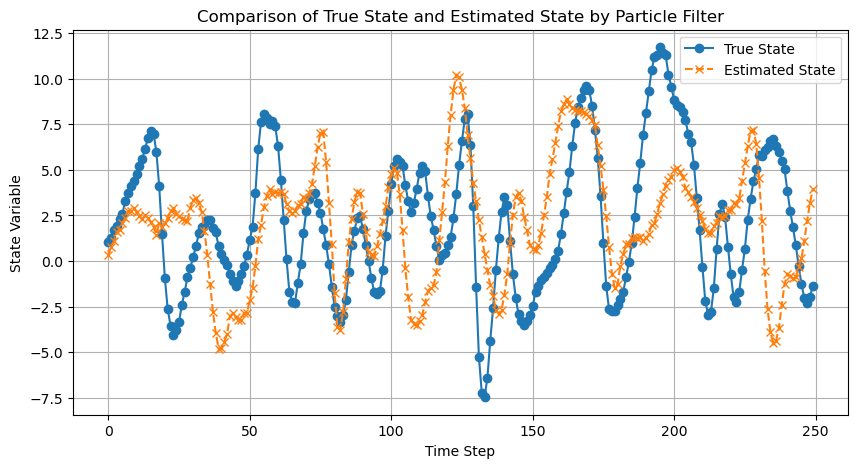

In [6]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random


num_particles = 100
particles = random.multivariate_normal(key, jnp.zeros(n), Q, shape=(num_particles,))

weights = jnp.ones(num_particles) / num_particles

estimated_states = []
for t, observation in enumerate(observations):
    particles, weights = particle_filter_step(particles, weights, l96_step, observation, H, Q, R, key)
    estimated_state = jnp.mean(particles, axis=0)  # Mean across particles as the state estimate
    estimated_states.append(estimated_state)
    key, _ = random.split(key)




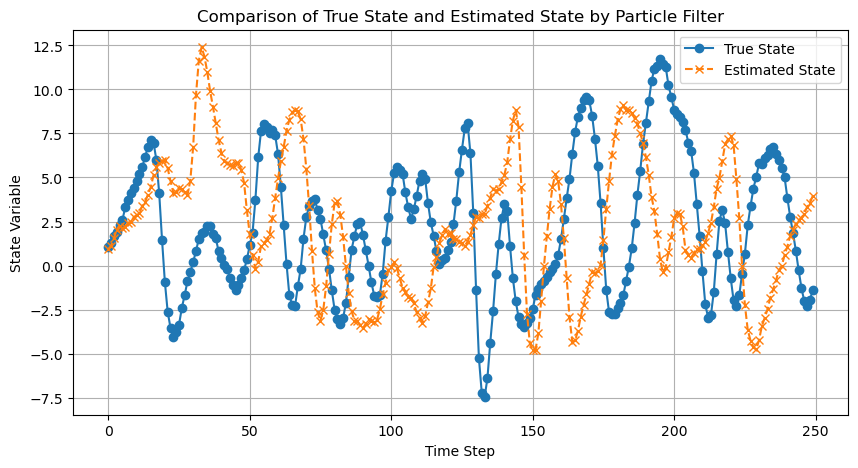

In [7]:
estimated_states = jnp.stack(m_pf)

plt.figure(figsize=(10, 5))
plt.plot(true_states[:, 0], label='True State', linestyle='-', marker='o')
plt.plot(estimated_states[:, 0], label='Estimated State', linestyle='--', marker='x')
plt.xlabel('Time Step')
plt.ylabel('State Variable')
plt.title('Comparison of True State and Estimated State by Particle Filter')
plt.legend()
plt.grid(True)
plt.show()